# `fmri-00`: Introduction to fMRI

This lab walks through some of the basics of fMRI research. First, we'll highlight the variety of software packages used in fMRI research. Next, we'll focus on the idea of a "coordinate space" with accompanying concepts like templates, atlases, and masking.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Part 1: The fMRI software ecosystem

Traditionally, fMRI researchers have relied on one of several software libraries for performing fMRI analysis. Packages such as [SPM](https://www.fil.ion.ucl.ac.uk/spm/) (MATLAB, UCL), [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/) (C/Python, Oxford), [AFNI](https://afni.nimh.nih.gov/) (C, NIMH), and [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) (C/MATLAB, MGH) are still the major workhouses for fMRI analysis. As the field of fMRI analysis has advanced (and as the wider fMRI community has grown more computationally savvy), there's been an increasing push to centralize and standardize tools and incorporate fMRI analysis into larger analytic workflows.

Recently, there's been a collosal effort to move fMRI analysis into the Python ecosystem (and also R). The most prominent example of this is [NIPY](https://nipy.org/), a constellation of python packages for (f)MRI preprocessing and analysis including:

- [nipype](https://nipype.readthedocs.io/en/latest/): a python pipeline framework that interfaces with existing neuroimaging software (the basis for [fMRIPrep](https://fmriprep.org/en/stable/))
- [nibabel](https://nipy.org/nibabel/): provides read/write protocols to many common neuroimaging file formats (e.g. [NIfTI](https://nifti.nimh.nih.gov/))
- [nilearn](https://nilearn.github.io/): comprehensive analytic toolkit for fMRI data
- [BrainIAK](https://brainiak.org/): advanced computational analysis tools for fMRI
- [nitime](http://nipy.org/nitime/): time-series analysis of data from neuroscience experiments
- [PyMVPA](http://www.pymvpa.org/): multivariate pattern analysis for neuroimaging data
- [CoSMoMVPA](https://www.cosmomvpa.org/): MATLAB port of PyMVPA
- [mindboggle](https://mindboggle.info/): automated labeling and morphometric analysis of human brain image data 
- [mne](http://martinos.org/mne/stable/index.html): software for M/EEG data analysis
- [lyman](https://github.com/mwaskom/lyman): python port of FSL
- [FIRdeconvolution](https://github.com/tknapen/FIRDeconvolution): deconvolution algorithms for timeseries data
- [neurodesign](https://github.com/neuropower/neurodesign): tools for fMRI experimental design and power analysis

Many software tools provide some basic visualization as well. However, there are also a variety of dedicated visualization tools:
- [MRIcron](https://people.cas.sc.edu/rorden/mricron/index.html): basic fMRI visualization
- [pycortex](https://gallantlab.github.io/pycortex/): advanced cortical surface visualizaiton
- [pysurfer](https://pysurfer.github.io/): cortical surface visualization in Python
- [Surf-Ice](https://github.com/neurolabusc/surf-ice): standalone software for cortical surface visualization

#### The Brain Imaging Data Structure (BIDS)
There has (finally) been widespread adoption of a standardized format for fMRI data as well as the accompanying metadata and derivatives: the [Brain Imaging Data Structure (BIDS)](https://bids.neuroimaging.io/). This has accelerated data sharing and allowed for the development of automated processing pipelines:

- [fMRIPrep](https://fmriprep.org/en/stable/): adaptive, automated preprocessing for fMRI data
- [MRIQC](https://mriqc.readthedocs.io/en/stable/): automated quality control for fMRI data
- [fitlins](https://github.com/poldracklab/fitlins): automated first-level analysis via fMRIPrep

#### Where to begin...
With so many options, the ecosystem for fMRI analysis can feel overwhelming. For this course, we'll be relying on only a handful of software packages with an emphasis on current best practices and the ubiquity of Python. We'll use [fMRIPrep](https://fmriprep.org/en/stable/) for automated preprocessing and [nilearn](https://nilearn.github.io/stable/index.html) for most downstream analyses. The [Princeton Handbook for Reproducible Neuroimaging](https://brainhack-princeton.github.io/handbook/) provides a good starting point.

This demo walks through the visualization of several types of fMRI data, including anatomical (T1-weighted) images, functional (T2*-weighted BOLD) images, and masks. We'll walk through several types of visualization for volumetric images, surface images, and time series data. We'll use two example datasets provided via [`nilearn`](https://nilearn.github.io/): [Haxby et al., 2001](https://doi.org/10.1126/science.1063736) and [Thirion et al., 2014](https://doi.org/10.1007/978-3-319-10470-6_92). For this demo, we'll need to install `nilearn` in our `conda`environment using `pip` (if you don't already have it). Run the following two commands on the command line: `conda activate neu502b` followed by `pip install nilearn`.

### Part 2: Coordinate space(s)

Over the course of fMRI processing, the functional data are often spatially transformed into another "space"—typically a standard space. We'll need to keep the following distinctions in mind during analysis:

* native space vs. standard space
* volume space vs. surface space
* standard space and templates, e.g. MNI152, MNI305, fsaverage
* voxel space vs. world space

#### Native space vs. standard space
The first distinction is between native and standard space. Native space refers to the subject-specific configuration under which the data were collected. Analyzing data in native space requires the minimal amount of data manipulation (e.g. aligning and resampling), but the lack of voxelwise correspondence across subjects prevents some types of group analysis. To achieve voxelwise correspondence across subjects, we typically perform spatial normalization to align each subject's data to a template image (e.g. *MNI152NLin2009cAsym*) in a standard space (e.g. *MNI space*). There are several standard spaces.

#### Volume space vs. surface space
The second distinction is between volume- and surface-based analysis. MRI data are collected in a volumetric format where each data point corresponds to a voxel at a particular location in a three-dimensional grid; volumetric analysis retains this three-dimensional grid representation of the data. In contrast, surface-based analysis is argued to better capture the sheet-like structure of the cortical mantle. In surace-based analysis, the functional data are resampled onto two-dimensional graph-like triangular mesh where each data point corresponds to a vertex at a particular location in the mesh. Importantly, two voxels on either side of a sulcus may appear to be close according to their Euclidean distance in volume space, whereas surface space more accurately that they are farther apart in terms of geodesic distance on the folded cortical surface. The *fsaverage* template is typically used for spatial normalization of surface-based data.

#### Standard space and templates
The third distinction is between a standard space and the specific *template* in that space. A template is an actual brain image (typically the average of many subjects) that serves as a target for alignment. Although "MNI space" is very widely used, there are in fact many specific *templates* in MNI space that each differ in small ways (read more [about the MNI space(s)](https://www.lead-dbs.org/about-the-mni-spaces/) at Lead-DBS).

#### Voxel space vs. world space
The fourth distinction is between voxel space and world space. A standard space (e.g. MNI space) is defined in real-world coordinates. However, any given brain image is rendered in a voxel space (or "image space") with a particular geometry and grid: i.e. voxel size, field of view, etc. The translation between the voxel space of a given brain image and real-world coordinates are stored in an matrix accompanying the data (called an *affine matrix*). When we align a brain image to a standard space, we align it in real-world coordinates, but then we resample (or slice it) onto a particular grid of voxels. Different brain images with different geometries (voxel size, field of view, etc) can all be *in* (i.e. *aligned to*) MNI space.

### Part 3: Working with volume data

#### Reading/writing data
The `nibabel` package is widely used for reading/writing fMRI data. Run `pip install nibabel` from within your `neu502b` conda environment to install `nibabel`. For a more complete tutorial, see [here](https://nipy.org/nibabel/gettingstarted.html). First, we'll use `nib.load` to load in an example T1-weighted anatomical image. Check the `type` of the loaded image object.

In [2]:
import nibabel as nib

# Load anatomical data
img = nib.load('T1w.nii.gz')
print(type(img))

<class 'nibabel.nifti1.Nifti1Image'>


This structural image is stored in the widely-used (g-zipped) [NIfTI](https://nifti.nimh.nih.gov/) (i.e. `.nii.gz`) file format. The `nibabel` object stores many useful pieces of information, including the data, the affine transformation, and the header. Below, inspect the header and affine matrix.

In [3]:
# Show header metadata
print(img.header.keys()[:10])

# Show affine matrix
print(img.affine)

['sizeof_hdr', 'data_type', 'db_name', 'extents', 'session_error', 'regular', 'dim_info', 'dim', 'intent_p1', 'intent_p2']
[[  -2.    0.    0.   74.]
 [   0.    0.    2. -109.]
 [   0.   -2.    0.   85.]
 [   0.    0.    0.    1.]]


To extract the actual (floating point) data, use the `.get_fdata` method. This yields a NumPy array (`np.ndarray`). Inspect the shape of the data, then use `matshow` to visualize some example slices of the data: slice `50` on the first axis, slice `45` on the second axis, slice `40` along the third axis. Visualize some other slices to better orient yourself.

(76, 76, 93)


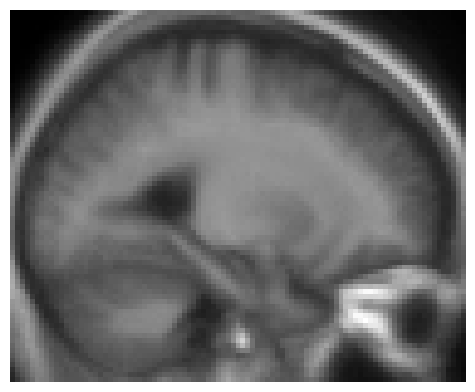

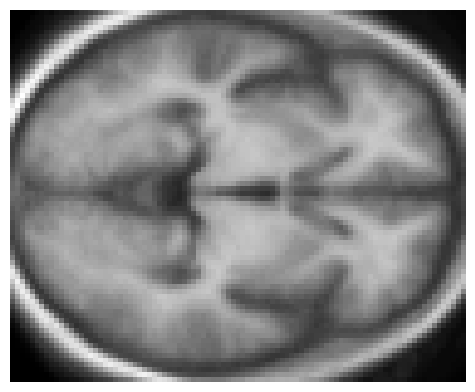

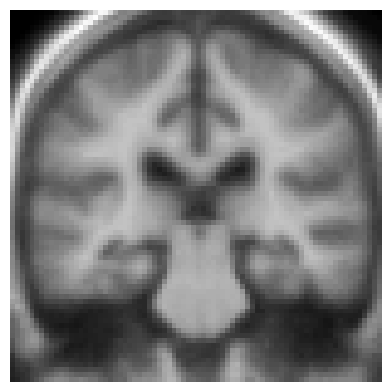

In [4]:
# Extract data
data = img.get_fdata()
print(data.shape)

# Visualize one slice along first axis
plt.matshow(data[50], cmap='binary_r')
plt.axis('off')

# Visualize one slice along second axis
plt.matshow(data[:, 45], cmap='binary_r')
plt.axis('off')

# Visualize one slice along third axis
plt.matshow(np.rot90(data[:, :, 40], k=3), cmap='binary_r')
plt.axis('off');

To save an image, we need to first convert our NumPy array back into a NIfTI image and provide (at minimum) an affine matrix. Here, we simply use the affine matrix that was contained in the NIfTI header when we loaded the data. Use `nib.Nifti1Image` to reinsert the NumPy array into a NIfTI image, then use `nb.save` to save it to disk using a filename with the `.nii.gz` extension.

In [5]:
# Convert data back into a NIfTI image
new_img = nib.Nifti1Image(data, img.affine)

# Save data to disk
filename = 'example.nii.gz'
nib.save(new_img, filename)

#### Masking volumetric data

Typically, we don't actually want to analyize an entire MRI image. We want to extract some subset of voxels based on a particular "mask"—for example, the entire brain (excluding everything outside the brain), only gray matter (excluding white matter, CSF, etc), or a particular region of interest (ROI; e.g. ventral temporal cortex). As long as our data and mask are in the same space and on the same grid, we can mask our data using simple NumPy indexing. Here, we demonstrate masking with the brainmask and with an anatomical atlas. Load in `brainmask.nii.gz` and extract the NumPy array. Inspect the shape of the mask, the unique values in the mask, and then visualize a slice (e.g. slice `50` in the first dimension) of the mask.

Data shape: (76, 76, 93)
Mask shape: (76, 76, 93)
Unique mask values: [0. 1.]


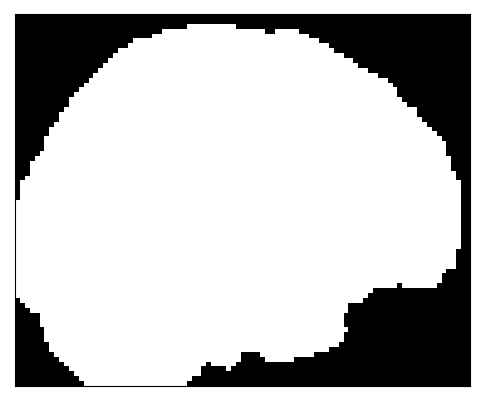

In [6]:
# Load brain mask
mask = nib.load('brainmask.nii.gz').get_fdata()
print(f"Data shape: {data.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Unique mask values: {np.unique(mask)}")

# Visualize one slice of mask
plt.matshow(mask[50], cmap='binary_r')
plt.xticks([])
plt.yticks([])
plt.show()

Next, make a copy of the data. Using the mask, zero out any values in the copy of the data that are not within the mask. Visualize a slice of the masked copy of the data.

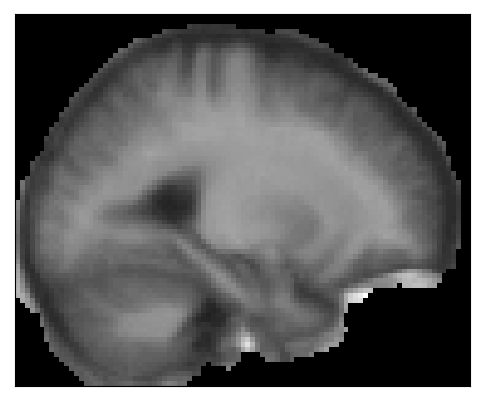

In [7]:
# Make copy of data
copy = data.copy()

# Zero out non-brain voxels for visualization
copy[mask == 0] = 0

# Visualize one slice
plt.matshow(copy[50], cmap='binary_r')
plt.xticks([])
plt.yticks([])
plt.show()

When we extract data based on a mask, the original 3-dimensional data array is collapsed into a single dimension. We can use `np.where` to keep track of where the masked voxels came from in the original image. First, count the total number of voxels in the entire mask image; then, count the number of nonzero voxels in the mask. Apply the mask to the data and inspect the shape of the resulting masked dataset.

In [8]:
# Count the voxels in our mask
mask_count = np.sum(mask != 0)
print(f"{mask.size} total voxels in image")
print(f"{mask_count} nonzero voxels in mask")

# Masked data is no longer 3-dimensional
masked_data = data[mask != 0]
print(f"Masked data shape: {masked_data.shape}")

537168 total voxels in image
304611 nonzero voxels in mask
Masked data shape: (304611,)


Use `np.where` to create an object called `mask_coords` that contains the three-dimensional indices where the mask image has nonzero values. Next, create an empty NumPy array (using `np.zeros`) matching the shape of the original image. Let's add some large perturbation to our masked dataset from the previous cell; e.g. add an array of random noise using `np.random.randn` with high variance (and with matching shape to the masked dataset) to the masked dataset. Finally, use `mask_coords` to reinsert the noisy 1D masked dataset back into our empty 3D array. Visualize a slice of the resulting image.

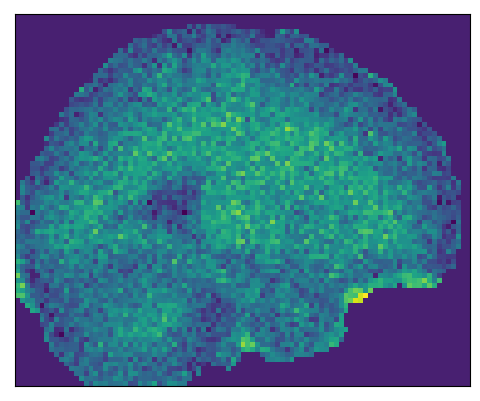

In [9]:
# Track the original mask coordinates
mask_coords = np.where(mask != 0)

# Create an empty new image with original shape
new_data = np.zeros(img.shape)

# Modify our masked data in some way
result = masked_data + np.random.randn(*masked_data.shape) * 20
new_data[mask_coords] = result

# Visualize one slice
plt.matshow(new_data[50])
plt.xticks([])
plt.yticks([])
plt.show()